In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pygmo import hypervolume
import numpy as np

In [2]:
data = pd.read_csv('../log/ls_size_evolution_20250529.csv', names = ['dataset', 'nodes', 'inutility', 'disclosure_averseness', 'pareto_nodes', 'seed', 'generation', 'timing'])

In [3]:
data.head()

,dataset,nodes,inutility,disclosure_averseness,pareto_nodes,seed,generation,timing
0,boston_8,5622,"[0.2187651577296664, 0.16324264867262858, 0.21...","[0.11166007905138339, 0.1482213438735178, 0.12...","[158, 100, 123, 105, 111, 78]",0,0,41.892199
1,boston_8,5987,"[0.07184008722399242, 0.1104034738935759, 0.47...","[0.23023715415019763, 0.1077075098814229, 0.10...","[78, 149, 133]",0,1,69.933147
2,boston_8,5533,"[0.1104034738935759, 0.47825029430729965, 0.04...","[0.1077075098814229, 0.10276679841897234, 0.12...","[149, 133, 133, 96, 140, 126]",0,2,48.903576
3,boston_8,5646,"[0.1104034738935759, 0.04918966625530328, 0.07...","[0.1077075098814229, 0.1274703557312253, 0.124...","[149, 133, 126, 119, 88]",0,3,47.433444
4,boston_8,5933,"[0.04918966625530328, 0.07420888526507792, 0.1...","[0.1274703557312253, 0.12450592885375493, 0.10...","[133, 126, 119, 121]",0,4,39.737852


In [4]:
data['latent_space'] =data['dataset'].apply(lambda x : '_'.join(x.split('_')[1:]))
data['dataset'] =data['dataset'].apply(lambda x : x.split('_')[0])

In [5]:
data2 = pd.read_csv('../log/evolution_20250527.csv', names = ['dataset', 'nodes', 'inutility', 'disclosure_averseness', 'pareto_nodes', 'seed', 'generation', 'timing'])
data2 = pd.concat((data2, pd.read_csv('../log/evolution_20250528.csv', names = ['dataset', 'nodes', 'inutility', 'disclosure_averseness', 'pareto_nodes', 'seed', 'generation', 'timing'])))

In [6]:
data2 = data2[data2['dataset'] != 'boston_only_normal']
data2['latent_space'] =data2['dataset'].apply(lambda x : '_'.join(x.split('_')[1:]))
data2['dataset'] =data2['dataset'].apply(lambda x : x.split('_')[0])

In [7]:
data2.replace({'pca_automation' : '2', 'same_shape' : '14'}, inplace = True)

In [8]:
data = pd.concat((data, data2[(data2.latent_space == '2') | (data2.latent_space == '14')])) 

In [9]:
# data2 = pd.read_csv('../log/evolution_20250520_True.csv', names = ['dataset', 'nodes', 'inutility', 'disclosure_averseness', 'pareto_nodes', 'seed', 'generation', 'timing'])
# data2 = data2[data2['dataset'] == 'boston']
# data2['latent_space'] = 'std'
# data = pd.concat((data, data2))

In [10]:
data.latent_space.unique()

array(['8', '28', '56', '140', '2', '14'], dtype=object)

In [11]:
data['n_elites'] = data['inutility'].apply(lambda x : len(eval(x)))

In [12]:
datas = data.dataset.unique()

In [13]:
def calculate_hypervolume(row):
    front = list(zip(eval(row['inutility']), eval(row['disclosure_averseness'])))
    hv = hypervolume(front)
    ref_point = [2, 0.5000001]
    # try:
    return hv.compute(ref_point)
    # except:
    #     return 0
    

In [14]:
def get_percentiles(row):
    x = eval(row['inutility'])
    idxs = []
    for p in [25, 50, 75]:
        pcen=np.percentile(x,p,interpolation='nearest')
        idxs.append(abs(x-pcen).argmin())
    return eval(row['inutility'])[idxs[0]], eval(row['inutility'])[idxs[1]], eval(row['inutility'])[idxs[2]], \
            eval(row['disclosure_averseness'])[idxs[0]], eval(row['disclosure_averseness'])[idxs[1]], eval(row['disclosure_averseness'])[idxs[2]]

In [15]:
# data['percentiles'] = data.apply(get_percentiles, axis = 1)

In [16]:
# data[['inutlity_25', 'inutlity_50', 'inutlity_75', 'disclosure_averseness_25',
#       'disclosure_averseness_50','disclosure_averseness_75']]                   = data['percentiles'].tolist()

In [17]:
data['hypervolume_indicator'] = data.apply(calculate_hypervolume, axis = 1)

In [18]:
latent_spaces = data.latent_space.unique()

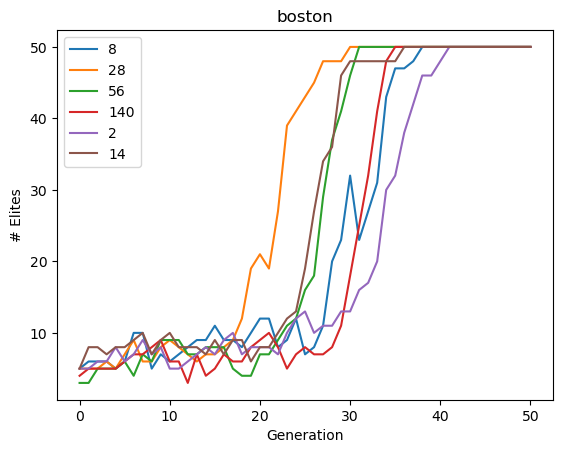

In [19]:
for dataset in datas:
    for ls in  latent_spaces:
    
        selected = data[(data['dataset'] == dataset) &
                        (data['latent_space'] == ls)][
                        ['generation', 'n_elites']].groupby('generation').median()
    
        plt.plot(selected.index, selected['n_elites'], label = ls)


    plt.legend()
    plt.title(dataset)
    plt.xlabel('Generation')
    plt.ylabel('# Elites')
    
    
    plt.show()


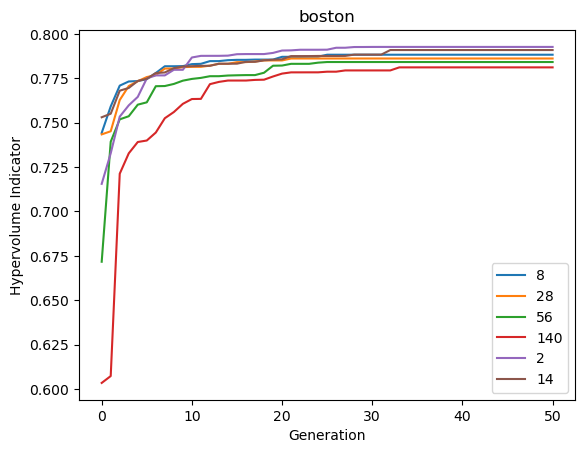

In [20]:
for dataset in datas:

    for ls in  latent_spaces:
    
        selected = data[(data['dataset'] == dataset)  &
                        (data['latent_space'] == ls)][
        ['generation', 'hypervolume_indicator']].groupby('generation').median()
    
        plt.plot(selected.index, selected['hypervolume_indicator'], label = ls)
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume Indicator')
    plt.title(dataset)
    plt.legend()
    
    plt.show()


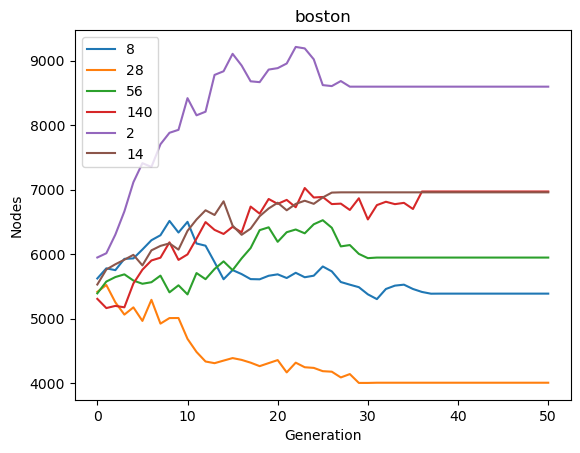

In [21]:
for dataset in datas:

    for ls in  latent_spaces:
        selected = data[(data['dataset'] == dataset) &
                       (data['latent_space'] == ls)][
        ['generation', 'nodes']].groupby('generation').median()
    
        plt.plot(selected.index, selected['nodes'], label =ls)
        
    plt.xlabel('Generation')
    plt.ylabel('Nodes')
    plt.title(dataset)
    plt.legend()
    
    plt.show()


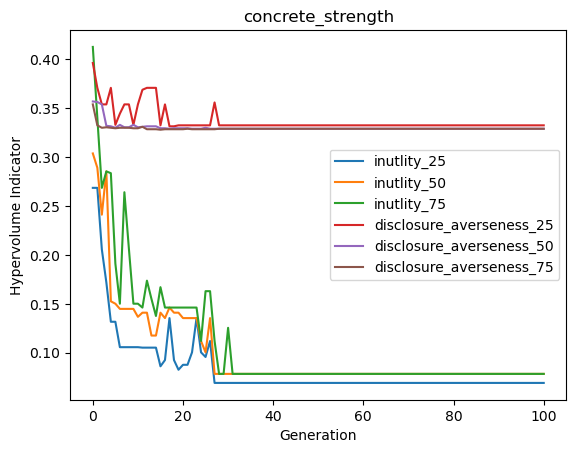

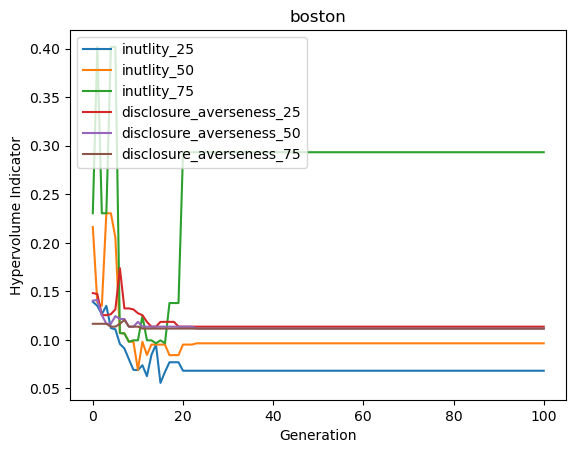

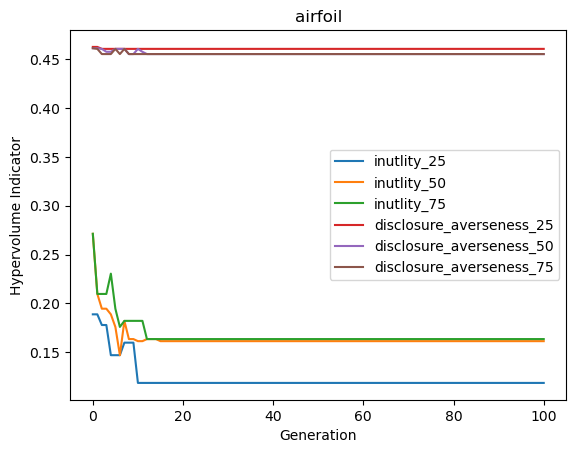

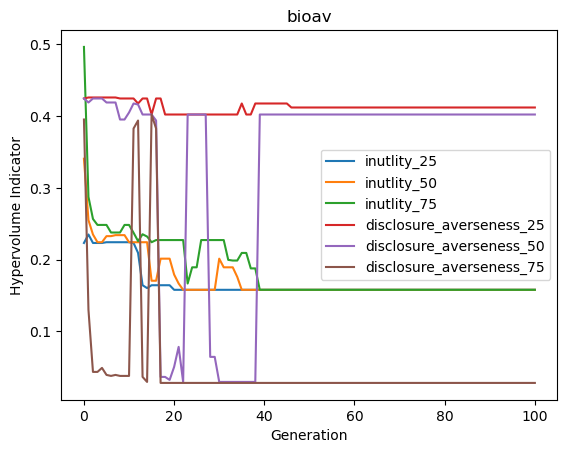

In [12]:
for dataset in datas:
    for metric in ['inutlity_25', 'inutlity_50', 'inutlity_75','disclosure_averseness_25', 'disclosure_averseness_50','disclosure_averseness_75']:
    
        selected = data[(data['dataset'] == dataset)][['generation',metric ]
                                                       ].groupby('generation').median()

        plt.plot(selected.index, selected[metric], label = metric)
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume Indicator')
    plt.title(dataset)
    plt.legend()
    plt.show()


In [13]:
data

,dataset,nodes,inutility,disclosure_averseness,pareto_nodes,seed,generation,timing,percentiles,inutlity_25,inutlity_50,inutlity_75,disclosure_averseness_25,disclosure_averseness_50,disclosure_averseness_75,hypervolume_indicator
0,concrete_strength,1481,"[0.303639805464869, 0.13169125748016627, 0.287...","[0.35373134328358224, 0.5, 0.4980099502487563,...","[97, 68, 75, 83]",0,0,21.859458,"(0.28734913236372106, 0.303639805464869, 0.303...",0.287349,0.303640,0.303640,0.498010,0.353731,0.353731,0.248157
1,concrete_strength,1636,"[0.303639805464869, 0.13169125748016627, 0.287...","[0.35373134328358224, 0.5, 0.4980099502487563,...","[97, 68, 75, 104, 116]",0,1,21.159489,"(0.28734913236372106, 0.303639805464869, 0.340...",0.287349,0.303640,0.340054,0.498010,0.353731,0.329353,0.289390
2,concrete_strength,1807,"[0.303639805464869, 0.13169125748016627, 0.287...","[0.35373134328358224, 0.5, 0.4980099502487563,...","[97, 68, 75, 104, 116, 112, 111]",0,2,15.889532,"(0.303639805464869, 0.3175756405229937, 0.3400...",0.303640,0.317576,0.340054,0.353731,0.353731,0.329353,0.290120
3,concrete_strength,2019,"[0.13169125748016627, 0.3400544562821882, 0.45...","[0.5, 0.32935323383084575, 0.3288557213930348,...","[68, 104, 116, 112, 94, 121, 99]",0,3,13.817563,"(0.273301834754396, 0.3328167246827167, 0.3400...",0.273302,0.332817,0.340054,0.353731,0.331841,0.329353,0.295003
4,concrete_strength,2032,"[0.13169125748016627, 0.3400544562821882, 0.45...","[0.5, 0.32935323383084575, 0.3288557213930348,...","[68, 104, 116, 112, 94, 116, 127, 68, 68, 87]",0,4,13.418740,"(0.13169125748016627, 0.273301834754396, 0.340...",0.131691,0.273302,0.340054,0.500000,0.353731,0.329353,0.308071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,bioav,43504,"[0.12841279242090484, 0.07803060771087914, 0.1...","[0.009776536312849202, 0.013966480446927387, 0...","[2177, 2150, 2177, 2177, 2217, 2177, 2177, 212...",4,96,136.970856,"(0.12841279242090484, 0.12841279242090484, 0.1...",0.128413,0.128413,0.128413,0.009777,0.009777,0.009777,0.950271
2016,bioav,43504,"[0.12841279242090484, 0.07803060771087914, 0.1...","[0.009776536312849202, 0.013966480446927387, 0...","[2177, 2150, 2177, 2177, 2217, 2177, 2177, 212...",4,97,136.654383,"(0.12841279242090484, 0.12841279242090484, 0.1...",0.128413,0.128413,0.128413,0.009777,0.009777,0.009777,0.950271
2017,bioav,43504,"[0.12841279242090484, 0.07803060771087914, 0.1...","[0.009776536312849202, 0.013966480446927387, 0...","[2177, 2150, 2177, 2177, 2217, 2177, 2177, 212...",4,98,136.669890,"(0.12841279242090484, 0.12841279242090484, 0.1...",0.128413,0.128413,0.128413,0.009777,0.009777,0.009777,0.950271
2018,bioav,43504,"[0.12841279242090484, 0.07803060771087914, 0.1...","[0.009776536312849202, 0.013966480446927387, 0...","[2177, 2150, 2177, 2177, 2217, 2177, 2177, 212...",4,99,137.643368,"(0.12841279242090484, 0.12841279242090484, 0.1...",0.128413,0.128413,0.128413,0.009777,0.009777,0.009777,0.950271


In [29]:
baselines = {'concrete_strength': [(0.0, 0.5), (0.5712910920430821, 0.1955223880597015)],
             'boston': [(0.0, 0.5), (0.6788396089001241, 0.28952569169960474)],
             'airfoil': [(0.0, 0.5), (0.7732035508463126, 0.4228210246174319)],
             'bioav': [(0.0, 0.49999999999999994), (0.2995160410175487, 0.3589385474860335)]}


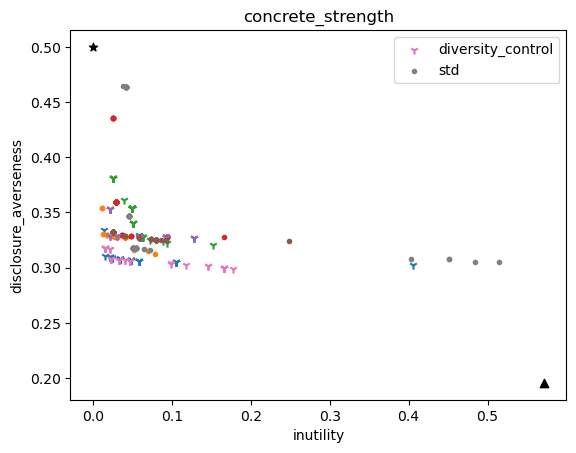

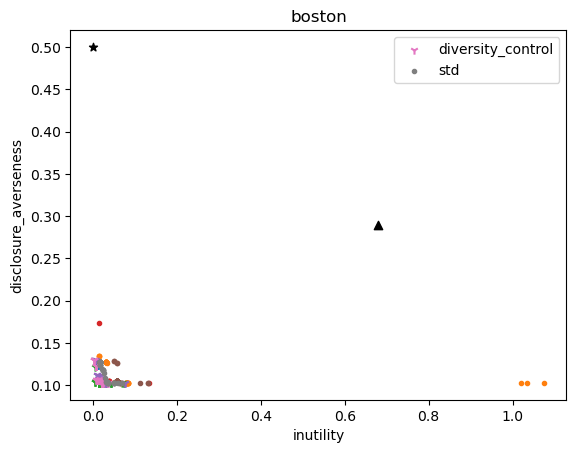

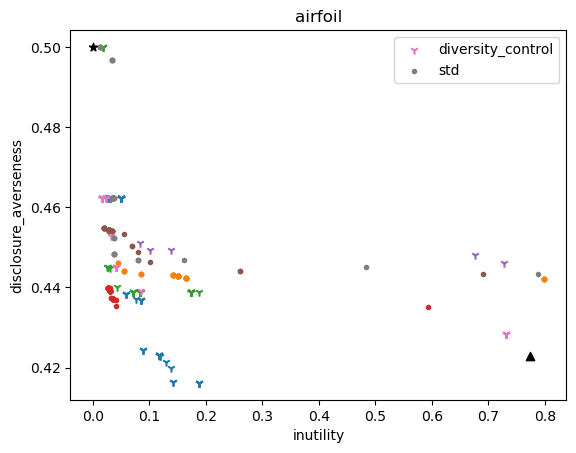

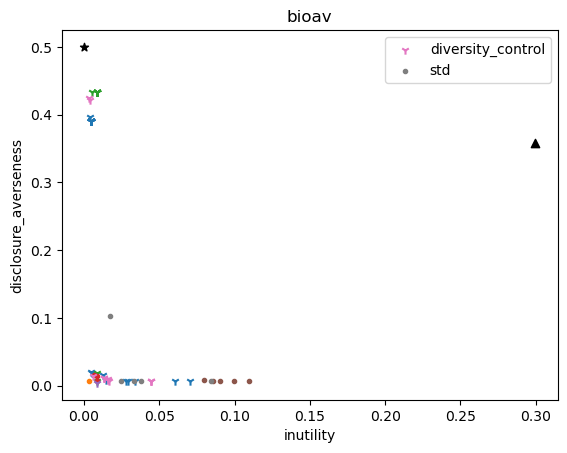

In [36]:
for dataset in datas:
    for seed in range(4):

        for rc in  [True, False]:

            selected = data[(data['generation'] == 50) &
                (data['dataset'] == dataset) &
                (data['seed'] == seed) &
                (data['remove_copies'] == rc)] 
            
            plt.scatter(eval(selected['inutility'].values[0]), eval(selected['disclosure_averseness'].values[0]), 
                        marker = '1' if rc else '.',
                        # alpha = 0.5,
                        label = ('diversity_control' if rc else 'std') if seed == 3 else None)

    plt.scatter(baselines[dataset][0][0], baselines[dataset][0][1], marker = "*", color = 'black')
    plt.scatter(baselines[dataset][1][0], baselines[dataset][1][1], marker = "^", color = 'black')
        
    plt.xlabel('inutility')
    plt.ylabel('disclosure_averseness')
    plt.title(dataset)
    plt.legend()
    plt.show()

In [38]:
data['inutility'] = data['inutility'].apply(lambda x : eval(x))

In [39]:
data['disclosure_averseness'] = data['disclosure_averseness'].apply(lambda x : eval(x))

In [43]:
for dataset in datas:
    print(dataset)
    for metric in ['inutility', 'disclosure_averseness']:
        print(metric)
        seed = np.argmin(data[(data['generation'] == 100) 
                & (data['dataset'] == dataset)][metric].values)
        print(seed, np.argmin(data[(data['generation'] == 100) 
                & (data['dataset'] == dataset) 
                &  (data['seed'] == seed)][metric].values))
    print('\n')

concrete_strength
inutility
2 0
disclosure_averseness
2 0


boston
inutility
0 0
disclosure_averseness
2 0


airfoil
inutility
2 0
disclosure_averseness
4 0


bioav
inutility
0 0
disclosure_averseness
4 0


